In [1]:
import mne
import numpy as np
from pathlib import Path

In [ ]:
preprocessed_path = Path("YOUR_PATH_HERE")  # Replace with your actual preprocessed data path

corr_list, inc_list, diff_list = [], [], []

for sub_dir in preprocessed_path.iterdir():
    if sub_dir.is_dir() and sub_dir.name.startswith("sub-"):
        subject_id = sub_dir.name
        print(f"Processing {subject_id}")
        
        # Fixed file patterns - note the .ave.fif extension
        correct_file = sub_dir / f"_desc-{subject_id}-evokedCorrect_ave.fif"
        incorrect_file = sub_dir / f"_desc-{subject_id}-evokedIncorrect_ave.fif"
        diff_file = sub_dir / f"_desc-{subject_id}-evokedDiff_ave.fif"
        
        
        # Check if all files exist
        if correct_file.exists() and incorrect_file.exists() and diff_file.exists():
            # Load the evoked data
            evoked_corr = mne.read_evokeds(correct_file)[0]
            evoked_inc = mne.read_evokeds(incorrect_file)[0]
            evoked_diff = mne.read_evokeds(diff_file)[0]
            
            corr_list.append(evoked_corr)
            inc_list.append(evoked_inc)
            diff_list.append(evoked_diff)
        else:
            print(f"  ??  Missing files for {subject_id}")

# Create grand averages
if all([corr_list, inc_list, diff_list]):
    grand_corr = mne.grand_average(corr_list)
    grand_inc = mne.grand_average(inc_list)
    grand_diff = mne.grand_average(diff_list)
    print(f"? Grand averages created from {len(corr_list)} subjects")

Identifying common channels ...


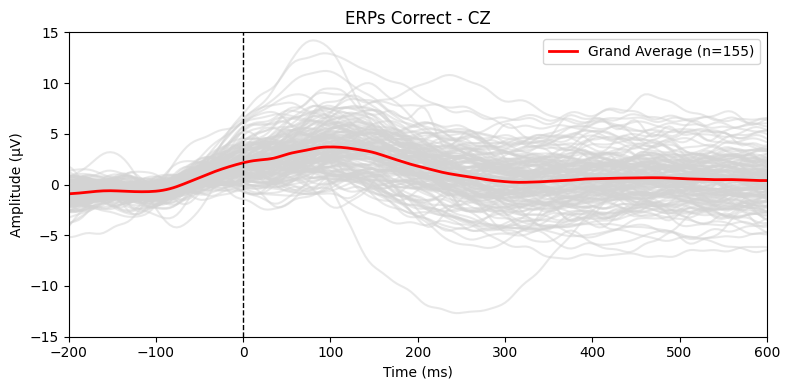

Identifying common channels ...


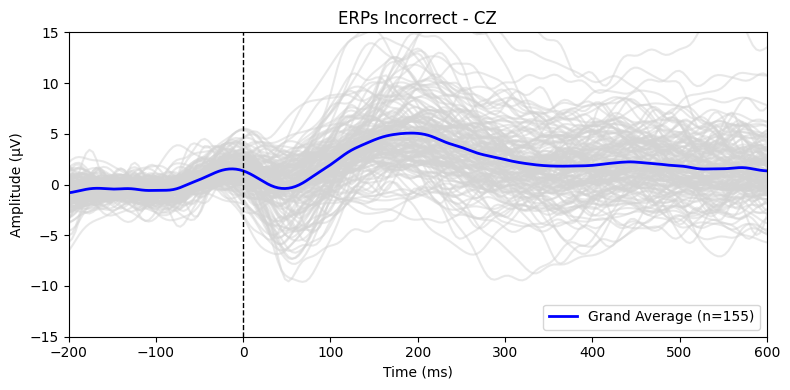

Identifying common channels ...


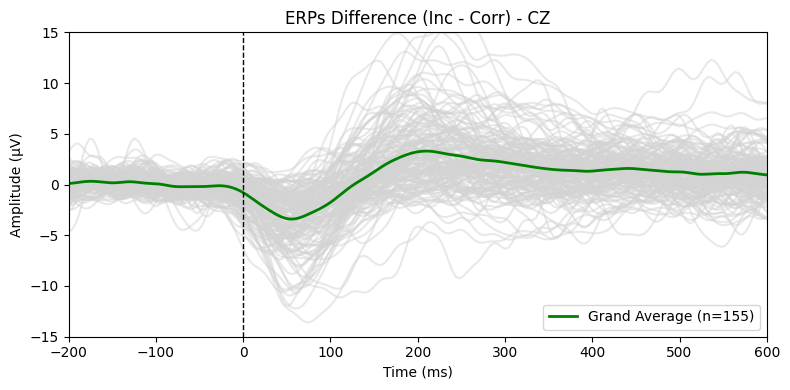

In [3]:
import matplotlib.pyplot as plt
import mne

def plot_erp_condition(evoked_list, title, color="red", channel="CZ"):
    """Plot individual ERPs and grand average for a condition"""
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot individual subjects
    for evoked in evoked_list:
        ch_idx = evoked.ch_names.index(channel)
        ax.plot(evoked.times * 1e3, evoked.data[ch_idx] * 1e6, 
                color="lightgray", alpha=0.5)
    
    # Plot grand average
    grand_avg = mne.grand_average(evoked_list)
    ch_idx = grand_avg.ch_names.index(channel)
    ax.plot(grand_avg.times * 1e3, grand_avg.data[ch_idx] * 1e6,
            color=color, lw=2, label=f"Grand Average (n={len(evoked_list)})")
    
    # Styling
    ax.axvline(0, color="black", linestyle="--", lw=1)
    ax.set(xlabel="Time (ms)", ylabel="Amplitude (µV)", title=title)
    ax.set_xlim(-200, 600)
    ax.set_ylim(-15, 15)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Create all plots
plot_erp_condition(corr_list, "ERPs Correct - CZ", color="red")
plot_erp_condition(inc_list, "ERPs Incorrect - CZ", color="blue")
plot_erp_condition(diff_list, "ERPs Difference (Inc - Corr) - CZ", color="green")

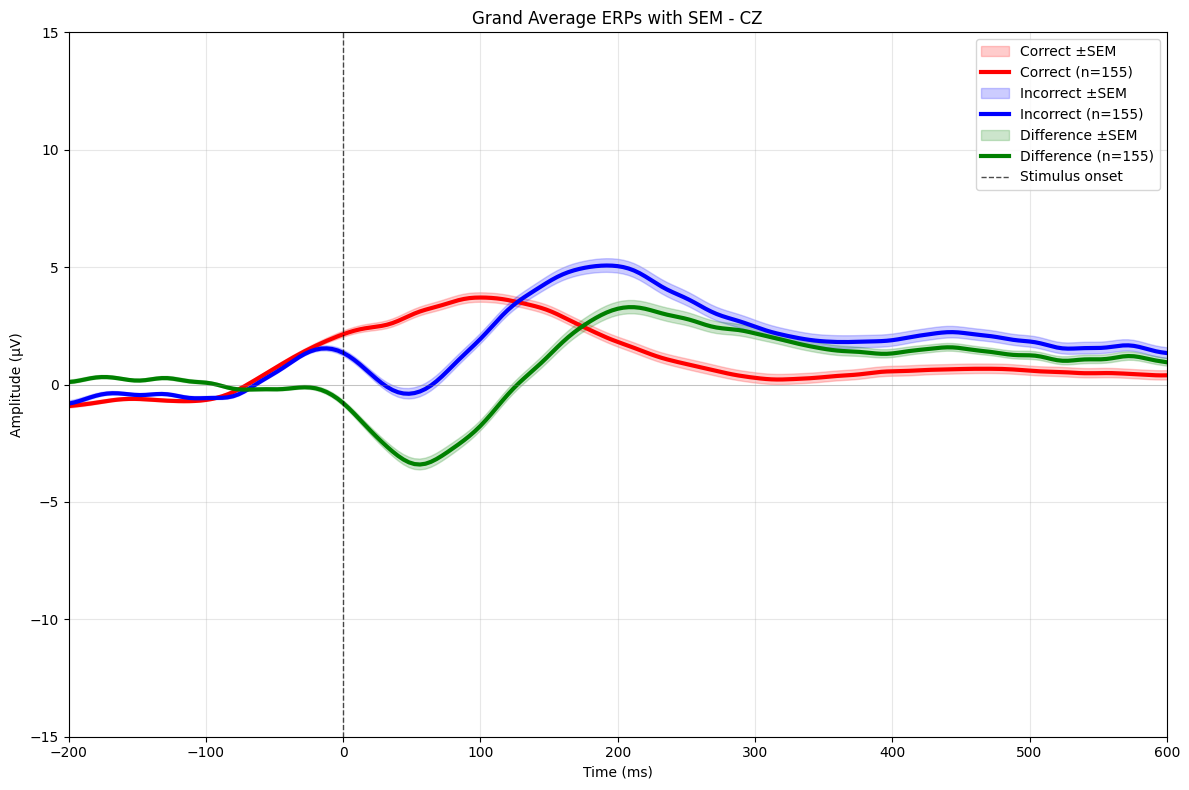


Summary Statistics:
--------------------------------------------------
   Correct: Peak at    100ms,   3.71µV (n=155)
 Incorrect: Peak at    192ms,   5.07µV (n=155)
Difference: Peak at     56ms,  -3.41µV (n=155)


In [4]:
fig, ax = plt.subplots(figsize=(12, 8))

conditions = [
    (corr_list, "red", "Correct"),
    (inc_list, "blue", "Incorrect"), 
    (diff_list, "green", "Difference")
]

for evoked_list, color, condition_name in conditions:
    # Get data from all subjects for this condition
    ch_idx = evoked_list[0].ch_names.index("CZ")
    times = evoked_list[0].times * 1e3  # Convert to ms
    
    # Stack data from all subjects
    data_matrix = np.array([evoked.data[ch_idx] * 1e6 for evoked in evoked_list])  # Convert to µV
    
    # Calculate mean and SEM
    mean_data = np.mean(data_matrix, axis=0)
    sem_data = np.std(data_matrix, axis=0) / np.sqrt(len(evoked_list))
    
    # Plot SEM as shaded area
    ax.fill_between(times, mean_data - sem_data, mean_data + sem_data,
                    color=color, alpha=0.2, label=f"{condition_name} ±SEM")
    
    # Plot grand average
    ax.plot(times, mean_data, color=color, lw=3,
            label=f"{condition_name} (n={len(evoked_list)})")

# Add reference lines
ax.axvline(0, color="black", linestyle="--", lw=1, alpha=0.7, label="Stimulus onset")
ax.axhline(0, color="gray", linestyle="-", lw=0.5, alpha=0.5)

# Styling
ax.set(xlabel="Time (ms)", ylabel="Amplitude (µV)",
       title="Grand Average ERPs with SEM - CZ")
ax.set_xlim(-200, 600)
ax.set_ylim(-15, 15)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 50)
for evoked_list, color, condition_name in conditions:
    ch_idx = evoked_list[0].ch_names.index("CZ")
    data_matrix = np.array([evoked.data[ch_idx] * 1e6 for evoked in evoked_list])
    mean_data = np.mean(data_matrix, axis=0)
    times = evoked_list[0].times * 1e3
    
    # Find peak (absolute maximum)
    peak_idx = np.argmax(np.abs(mean_data))
    peak_time = times[peak_idx]
    peak_amplitude = mean_data[peak_idx]
    
    print(f"{condition_name:>10}: Peak at {peak_time:6.0f}ms, {peak_amplitude:6.2f}µV (n={len(evoked_list)})")